<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-задачи" data-toc-modified-id="Описание-задачи-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание задачи</a></span></li><li><span><a href="#Выгрузка-библиотек" data-toc-modified-id="Выгрузка-библиотек-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Выгрузка библиотек</a></span></li><li><span><a href="#Написание-функции" data-toc-modified-id="Написание-функции-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Написание функции</a></span></li></ul></div>

# Отправка в телеграм канал среза по основнм показателям приложения 

## Описание задачи

**Дано**: данные по мобильному приложению некоторой социальной сети  
**Найти**: необходимо получать срез в телеграме по основным показателям, за интересующий день  

У нас есть данные по работе некоторой социальной сети, где каждое событие - это какое-либо действие пользователя:
- публикация постов
- отправка сообщений
- лайки постов
- просмотры постов


## Выгрузка библиотек

In [25]:
import pandas as pd
import numpy as np
import os
import io

#общие штуки для рисования
import seaborn as sns
import matplotlib.pyplot as plt
from telegram import Bot
import asyncio
from dotenv import load_dotenv

df=pd.read_csv(r'C:\Users\Yana\Documents\Симулятор DA\data 20250220\feed_actions1.csv')
df.head()

,user_id,post_id,action,time,gender,age,country,city,os,source,exp_group,rn
0,106791,76,view,2025-01-04 00:26:19,0,45,Russia,Chelyabinsk,iOS,ads,3,1
1,659,76,view,2025-01-04 00:26:31,0,30,Russia,Partizansk,Android,ads,0,2
2,106791,76,like,2025-01-04 00:27:59,0,45,Russia,Chelyabinsk,iOS,ads,3,3
3,695,76,view,2025-01-04 00:29:39,1,27,Russia,Engels,Android,ads,0,4
4,695,76,like,2025-01-04 00:29:51,1,27,Russia,Engels,Android,ads,0,5


## Написание функции

In [23]:
#Функция отправки отчета в телеграм 


# Загружаем переменные из .env
load_dotenv()

async def logbook_shu(filter_date, chat=None):
    chat_id = chat or "1261141345"
    my_token = os.getenv("TELEGRAM_TOKEN")
    
    # Создаем объект бота
    bot = Bot(token=my_token)
    
    #получаем и преобразуем данные
    df=pd.read_csv(r'C:\Users\Yana\Documents\Симулятор DA\data 20250220\feed_actions1.csv')
    # Преобразуем столбец 'time' в формат datetime
    df['time'] = pd.to_datetime(df['time'])
    # Фильтруем данные по дате 
    
    df1 = df[df['time'].dt.date == pd.to_datetime(filter_date).date()]

    # Группируем по дате и действию (action) и считаем уникальных пользователей
    df1 = df1.groupby([df1['time'].dt.date]).agg(
        dau=('user_id', 'nunique'),
        likes=('action', lambda x: (x == 'like').sum()),
        views=('action', lambda x: (x == 'view').sum())
    ).reset_index()

    df1['ctr']=df1['likes']/df1['views']
    
    df1['time']=pd.to_datetime(df1['time'])
  
    
    
    #текст с информацией о значениях ключевых метрик за предыдущий день
    msg = (
        f" Журнал основных показателей за {df1['time'].dt.strftime('%d.%m.%Y')[0]}:\n"
        f" \n"
        f"🔵 DAU: {df1['dau'][0]}\n"
        f"🔵 Просмотры: {df1['views'][0]}\n"
        f"🔵 Лайки: {df1['likes'][0]}\n"
        f"🔵 CTR: {df1['ctr'][0] * 100:.2f}%"
    )
    
    print(msg)

    # Отправка текстового сообщения (await обязательно!)
    await bot.send_message(chat_id=chat_id, text=msg)
    
    # Обработка данных за неделю ранее
    df2 = df[(df['time'] >= pd.to_datetime(filter_date)-pd.Timedelta(days=7)) & (df['time'] < pd.to_datetime(filter_date)+ pd.Timedelta(days=1))]

    # Группируем по дате и действию (action) и считаем уникальных пользователей
    df2 = df2.groupby([df2['time'].dt.date]).agg(
        dau=('user_id', 'nunique'),
        likes=('action', lambda x: (x == 'like').sum()),
        views=('action', lambda x: (x == 'view').sum())
    ).reset_index()

    df2['ctr']=df2['likes']/df2['views']
    df2['time']=pd.to_datetime(df2['time'])
    
    
    # Создаем фигуру с четырьмя подграфиками (2 строки, 2 столбца)
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    data_plot=df2['time'].dt.strftime('%d %b')


    sns.set(style="darkgrid", rc={"axes.labelsize": 0})  # Убираем подписи осе
    # График DAU
    sns.lineplot(ax=axes[0, 0], data=df2, x=data_plot, y='dau', marker='h', markersize='6', color = '#9e2a2f')
    axes[0, 0].set_title('DAU')

    # График Views
    sns.lineplot(ax=axes[0, 1], data=df2, x=data_plot, y='views', marker='o', markersize='6', color = '#D65F29')
    axes[0, 1].set_title('Просмотры')

    # График Likes
    sns.lineplot(ax=axes[1, 0], data=df2, x=data_plot, y='likes', marker='o', markersize='6', color = '#D65F29')
    axes[1, 0].set_title('Лайки')

    # График CTR
    sns.lineplot(ax=axes[1, 1], data=df2, x=data_plot, y='ctr', marker='h', markersize='6', color = '#9e2a2f')
    axes[1, 1].set_title('CTR')

    # Настройки общие для всех графиков
    for ax in axes.flat:
        ax.set_ylabel('Значение')
        ax.grid(True)

    # Улучшаем расположение графиков
    plt.tight_layout()


    plot_object = io.BytesIO()
    plt.savefig(plot_object)
    plot_object.seek(0)
    plot_object.name = 'plot.png'
    plt.close()
    
    # Отправка изображения в Telegram 
    await bot.send_photo(chat_id=chat_id, photo=plot_object)
    
await logbook_shu(filter_date = '2025-01-27', chat='-1002358101307')   


 Журнал основных показателей за 27.01.2025:
 
🔵 DAU: 2149
🔵 Просмотры: 9916
🔵 Лайки: 2084
🔵 CTR: 21.02%


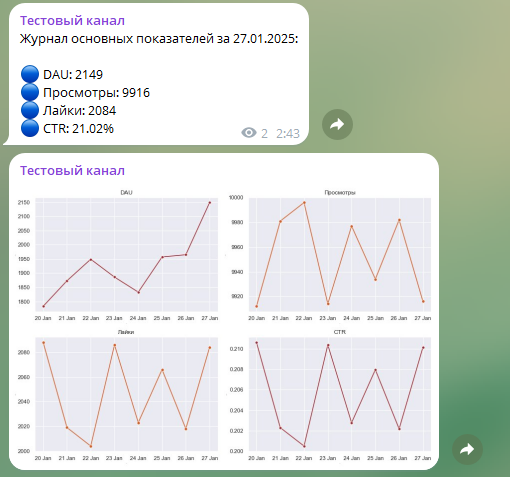